In [76]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os.path
from pyspark.sql.functions import *
from datetime import timedelta, date
import json
from pyspark.sql.types import *
import sys
import urllib.parse
import builtins

spark = sqlContext = SQLContext(sc)

%matplotlib inline

sys.path.append("/home/piccardi/libs/tldextract-2.2.1-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/tldextract-2.2.1-py3.5.egg")

sys.path.append("/home/piccardi/libs/requests_file-1.4.3-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/requests_file-1.4.3-py3.5.egg")


sys.path.append("/home/piccardi/libs/seaborn-0.9.0-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/seaborn-0.9.0-py3.5.egg")


sys.path.append("/home/piccardi/libs/idna-2.8-py3.5.egg")
sc.addPyFile("/home/piccardi/libs/idna-2.8-py3.5.egg")

import tldextract
import seaborn as sns


In [77]:
filter_30_days = "event_time >= '2019-03-24' AND event_time <= '2019-04-20' AND page_id > 0"
anonymous_citationusage = spark.read.parquet("april_anonymous_citationusage.parquet")\
                                            .where(filter_30_days).where("action <> 'pageLoad'")
pageloads = spark.read.parquet("april_anonymous_pageloads.parquet")\
                                            .where(filter_30_days)
unique_sessions = pageloads.select("session_token").distinct()
anonymous_citationusage.registerTempTable("anonymous_citationusage")
unique_sessions.registerTempTable("unique_sessions")

query = """
select anonymous_citationusage.* 
from anonymous_citationusage
join unique_sessions
on anonymous_citationusage.session_token = unique_sessions.session_token
"""

citationusage = spark.sql(query)

In [3]:
pageloads.select("page_id").distinct().count()

5478083

In [4]:
pageloads.select("revision_id").distinct().count()

7376696

## Events info - 100% sampling

In [5]:
events_counts = anonymous_citationusage.groupBy("action", "mode").agg(count("*").alias("total")).toPandas()
events_counts.head()

,action,mode,total
0,fnHover,desktop,30689719
1,fnHover,mobile,1820686
2,extClick,mobile,17407904
3,extClick,desktop,25929146
4,upClick,desktop,775376


In [6]:
events_counts['perc'] = events_counts["total"] / builtins.sum(events_counts["total"])
events_counts

,action,mode,total,perc
0,fnHover,desktop,30689719,0.316465
1,fnHover,mobile,1820686,0.018774
2,extClick,mobile,17407904,0.179506
3,extClick,desktop,25929146,0.267375
4,upClick,desktop,775376,0.007995
5,fnClick,desktop,6797773,0.070097
6,fnClick,mobile,13456662,0.138762
7,upClick,mobile,99431,0.001025


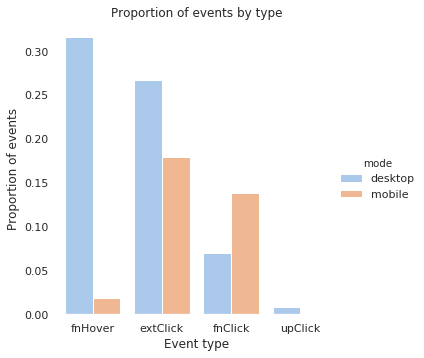

In [8]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.2)  # crazy big
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


fig=sns.catplot(y='perc', x='action', hue='mode', 
                data=events_counts.sort_values("total", ascending=False), 
                kind='bar', palette="pastel")
fig.ax.set(xlabel='Event type', ylabel='Proportion of events', title="Proportion of events by type")
fig.ax.ticklabel_format(style='plain', axis='y')
fig.savefig("out.pdf")

Total events:

In [6]:
events_counts.total.sum()

96976697

# Events info - 100% sampling - with refClick

In [20]:
# anonymous_citationusage.selectExpr("mode", 
# "case when action='extClick' and footnote_number is not null then 'refClick'else action end as action").show(200)

In [21]:
events_counts = anonymous_citationusage.selectExpr(
    "mode", 
    "case when action='extClick' and footnote_number is not null then 'refClick' else action end as action")\
     .groupBy("action", "mode").agg(count("*").alias("total")).toPandas()
events_counts.head()

,action,mode,total
0,refClick,mobile,4287207
1,refClick,desktop,10011621
2,fnHover,desktop,30689719
3,fnHover,mobile,1820686
4,extClick,mobile,13120697


In [23]:
events_counts['perc'] = events_counts["total"] / builtins.sum(events_counts["total"])
events_counts

,action,mode,total,perc
0,refClick,mobile,4287207,0.044209
1,refClick,desktop,10011621,0.103237
2,fnHover,desktop,30689719,0.316465
3,fnHover,mobile,1820686,0.018774
4,extClick,mobile,13120697,0.135297
5,extClick,desktop,15917525,0.164138
6,upClick,desktop,775376,0.007995
7,fnClick,desktop,6797773,0.070097
8,fnClick,mobile,13456662,0.138762
9,upClick,mobile,99431,0.001025


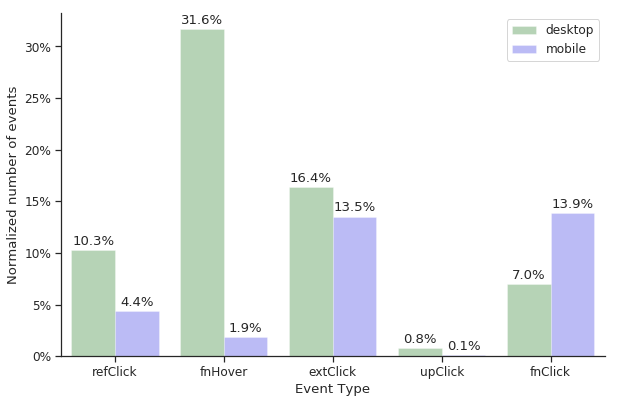

In [76]:
import numpy as np

sns.set(font_scale=1.2)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 3
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.005
            value = '{:,.1%}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


my_pal = {"desktop": "green", "mobile": "blue"}
fig = sns.catplot(y='perc', x='action', hue='mode', alpha=0.3,
                data=events_counts, kind='bar', palette=my_pal, 
                  legend=False, hue_order=["desktop", "mobile"])
fig.ax.set(xlabel='Event Type', ylabel='Normalized number of events')
fig.ax.ticklabel_format(style='plain', axis='y')
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.gcf().set_size_inches(10, 6)
plt.legend(loc='upper right')

show_values_on_bars(fig.ax)

plt.savefig('events_distribution.pdf', bbox_inches='tight')


## Page-loads events

In [53]:
pageloads_counts = pageloads.groupBy("mode").agg(count("*").alias("total")).toPandas()
pageloads_counts.head()

,mode,total
0,desktop,567789736
1,mobile,941262758


In [54]:
import builtins

pageloads_counts["perc"] = pageloads_counts["total"] / builtins.sum(pageloads_counts["total"])
pageloads_counts

,mode,total,perc
0,desktop,567789736,0.376256
1,mobile,941262758,0.623744


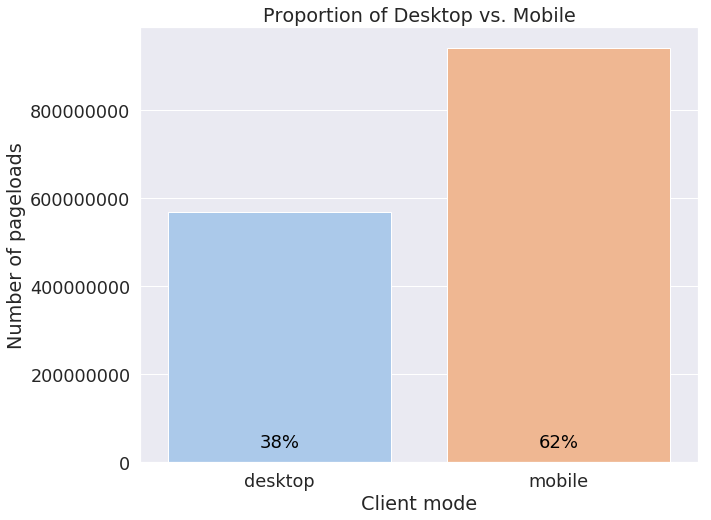

In [56]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)  # crazy big

ax = sns.barplot(x="mode", y="total", data=pageloads_counts, palette="pastel")
ax.set(xlabel='Client mode', ylabel='Number of pageloads', title="Proportion of Desktop vs. Mobile")
ax.ticklabel_format(style='plain', axis='y')

ax.annotate("38%", (ax.patches[0].get_x() + ax.patches[0].get_width() / 2., 0.3),
                 ha='center', va='center', fontsize=18, color='black', xytext=(0, 20),
                 textcoords='offset points')
ax.annotate("62%", (ax.patches[1].get_x() + ax.patches[0].get_width() / 2., 0.3),
                 ha='center', va='center', fontsize=18, color='black', xytext=(0, 20),
                 textcoords='offset points')

# ax.get_figure().savefig("output.pdf")

In [10]:
pageloads_counts.total.sum()

1509052494

## References click frequency

Overall:

In [78]:
# Get the page_id of the articles with references
wikipedia_references = spark.read.parquet("april2019_wikipedia_references.parquet")
articles_with_references = wikipedia_references.select("page_id").distinct().cache()

In [10]:
pageloads_withrefs_count = pageloads.join(articles_with_references, 
                                          pageloads.page_id==articles_with_references.page_id)\
        .select("page_token").distinct().count()
pageloads_withrefs_count

1451250502

In [13]:
refclicks_count = citationusage.where("action='extClick' and footnote_number is not null")\
    .select("page_token").distinct().count()
refclicks_count

4293371

In [14]:
refclicks_count/pageloads_withrefs_count

0.002958394153237647

Desktop:

In [9]:
pageloads_desktop = pageloads.where("mode='desktop'")
pageloads_withrefs_count = pageloads_desktop.join(articles_with_references, 
                                          pageloads_desktop.page_id==articles_with_references.page_id)\
        .select("page_token").distinct().count()

refclicks_count = citationusage.where("action='extClick' and footnote_number is not null and mode='desktop'")\
    .select("page_token").distinct().count()

print(pageloads_withrefs_count)
print(refclicks_count)
print(refclicks_count/pageloads_withrefs_count)

540397127
3053191
0.00564990235412558


In [79]:
pageloads_desktop = pageloads.where("mode='desktop'")
loads_by_page = pageloads_desktop.groupBy("page_id").agg(countDistinct("page_token").alias("pageloads"))

refclicks_count = citationusage.where("action='extClick' and footnote_number is not null and mode='desktop'")\
    .groupBy("page_id").agg(countDistinct("page_token").alias("with_clicks"))

loads_by_page_withrefs = loads_by_page.alias("l").join(articles_with_references, 
                                          loads_by_page.page_id==articles_with_references.page_id)\
                            .select("l.*")

loads_by_page_withrefs.registerTempTable("loads_by_page_withrefs")
refclicks_count.registerTempTable("refclicks_count")

query = """
SELECT l.*, CASE WHEN c.page_id IS NULL THEN 0 ELSE c.with_clicks END AS with_clicks
FROM loads_by_page_withrefs l
LEFT JOIN refclicks_count c
ON l.page_id=c.page_id
"""

ct_rate = spark.sql(query).selectExpr("*", "with_clicks/pageloads as ct_rate")


ct = ct_rate.select("page_id", "pageloads","ct_rate").toPandas()
ct.head()


,page_id,pageloads,ct_rate
0,1677,3936,0.000254
1,1697,2760,0.003986
2,1806,28001,0.001821
3,1950,2675,0.010467
4,2250,302,0.033113


In [17]:
ct.sort_values("ct_rate", ascending=False).head(10)

,pageloads,ct_rate
2056960,1,2.000000
917900,1,2.000000
1194200,1,2.000000
2039760,44,1.772727
2401717,30,1.100000
912593,1,1.000000
915436,1,1.000000
2405959,1,1.000000
1173627,1,1.000000
2566610,1,1.000000


In [12]:
ct[(ct.pageloads==1)].count()

page_id      422995
pageloads    422995
ct_rate      422995
dtype: int64

In [22]:
ct[(ct.pageloads<10)&(ct.ct_rate>0)].count()

pageloads    79832
ct_rate      79832
dtype: int64

In [26]:
ct[ct.pageloads<100].mean()

pageloads    17.693325
ct_rate       0.012462
dtype: float64

In [24]:
ct.mean()

pageloads    134.681659
ct_rate        0.011491
dtype: float64

Mobile:

In [16]:
pageloads_mobile = pageloads.where("mode='mobile'")
pageloads_withrefs_count = pageloads_mobile.join(articles_with_references, 
                                          pageloads_mobile.page_id==articles_with_references.page_id)\
        .select("page_token").distinct().count()

refclicks_count = citationusage.where("action='extClick' and footnote_number is not null and mode='mobile'")\
    .select("page_token").distinct().count()

print(pageloads_withrefs_count)
print(refclicks_count)
print(refclicks_count/pageloads_withrefs_count)

910853752
1240180
0.0013615577663009944


In [13]:
pageloads_desktop = pageloads.where("mode='mobile'")
loads_by_page = pageloads_desktop.groupBy("page_id").agg(countDistinct("page_token").alias("pageloads"))

refclicks_count = citationusage.where("action='extClick' and footnote_number is not null and mode='mobile'")\
    .groupBy("page_id").agg(countDistinct("page_token").alias("with_clicks"))

loads_by_page_withrefs = loads_by_page.alias("l").join(articles_with_references, 
                                          loads_by_page.page_id==articles_with_references.page_id)\
                            .select("l.*")

loads_by_page_withrefs.registerTempTable("loads_by_page_withrefs")
refclicks_count.registerTempTable("refclicks_count")

query = """
SELECT l.*, CASE WHEN c.page_id IS NULL THEN 0 ELSE c.with_clicks END AS with_clicks
FROM loads_by_page_withrefs l
LEFT JOIN refclicks_count c
ON l.page_id=c.page_id
"""

ct_rate = spark.sql(query).selectExpr("*", "with_clicks/pageloads as ct_rate")


ct_mobile = ct_rate.select("page_id", "pageloads","ct_rate").toPandas()
ct_mobile.head()


,page_id,pageloads,ct_rate
0,1677,4777,0.000000
1,1697,7338,0.000681
2,1806,81803,0.000122
3,1950,3796,0.000527
4,2250,561,0.000000


In [43]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [44]:
ct_mobile.mean()

page_id     25520523.11642
pageloads        244.12349
ct_rate            0.00529
dtype: float64

In [45]:
ct_mobile[ct_mobile.pageloads>=100].mean()

page_id     15894911.37081
pageloads       1117.12869
ct_rate            0.00215
dtype: float64

In [46]:
len(ct)

4012459

In [47]:
len(ct_mobile)

3731127

In [50]:
ct.sort_values("pageloads", ascending=False).head(10)

,page_id,pageloads,ct_rate
1767369,62233,582189,0.00276
482890,59462174,433730,0.00540
3220913,25965399,378251,0.00776
3309074,53470508,365030,0.00261
1836105,20715044,315549,0.00129
1139984,43613050,289800,0.00326
2024358,49676285,288997,0.00173
2647189,53785363,242746,0.00650
1722607,44254295,235472,0.00431
1547274,19364,234840,0.00077


In [51]:
ct_mobile.sort_values("pageloads", ascending=False).head(10)

,page_id,pageloads,ct_rate
2995746,25965399,1864184,0.00113
1643014,62233,1212687,0.00022
952390,68244,1191115,0.00033
1438255,19364,907374,0.00012
2053246,43356,805271,0.00024
1882242,49676285,772409,0.00042
3418392,4769444,754435,0.00077
1060227,43613050,725454,0.00018
3077617,53470508,670061,0.00041
1585427,54162498,636678,0.00079


In [14]:
import scipy.stats as stats

m = ct_mobile.sort_values("pageloads", ascending=False)
d = ct.sort_values("pageloads", ascending=False)

tau, p_value = stats.kendalltau(m.head(500).page_id, d.head(500).page_id)
print(tau)
print(p_value)

-0.048993987976
0.101510317846


In [15]:
t = []
p = []
for i in range(2, 1000, 5):
    tau, p_value = stats.kendalltau(m.head(i).page_id, d.head(i).page_id)
    t.append(tau)
    p.append(p_value)

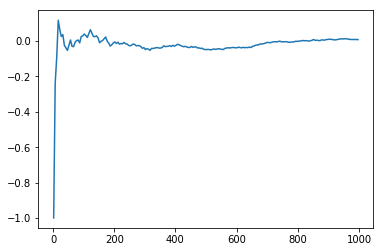

In [16]:
plt.plot(range(2, 1000, 5), t)

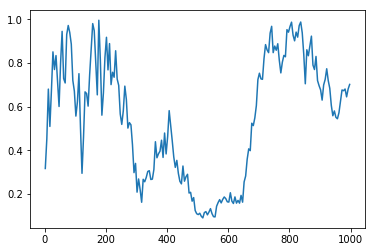

In [17]:
plt.plot(range(2, 1000, 5), p)

-----
## Clicked links study

In [7]:
references_click = anonymous_citationusage.where("action='extClick' and footnote_number is not null")

from urllib.parse import urlparse

def get_domain(row):
    try:
        parts = urlparse(row.link_url)
        url = parts.netloc
        if parts.netloc=='web.archive.org' or parts.netloc=='archive.is':
            pos = parts.path.index('http')
            url = parts.path[pos:]
        domain_parts = tldextract.extract(url)
        return (domain_parts.domain+"."+domain_parts.suffix, 1)
    except:
        return None

domains_count = spark.createDataFrame(references_click.rdd.map(get_domain).filter(lambda a: a is not None)\
        .reduceByKey(lambda a,b:a+b).map(lambda r: Row(host=r[0], clicks_count=r[1])))\
        .sort(col("clicks_count").desc())

In [8]:
top_clicked_domains = domains_count.limit(100).toPandas()

In [10]:
# top_clicked_domains.to_pickle("top_clicked_domains.pkl")

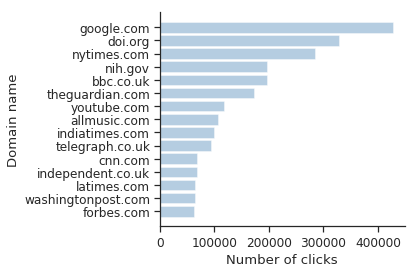

In [80]:
import numpy as np
import matplotlib.pyplot as plt

top=top_clicked_domains.head(15).sort_values("clicks_count", ascending=True)
# plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ind = np.arange(len(top))
# p = top.plot.barh(x="host", y="clicks_count", ax=ax, alpha=0.4, color="red")
# p = ax.bar(top.host , top.clicks_count, alpha=0.4)


# ax=fig.add_subplot(111)

idx=top.host.tolist()
x = range(len(idx))

plt.barh(x, top.clicks_count, alpha=0.4, color="steelblue")
plt.yticks(x, idx)

# ax.set_xticklabels([x for x in range(0, 900000, 10000)])
# ax.set_yticklabels(top.host)
ax.set_xlabel("Number of clicks")
ax.set_ylabel('Domain name')

# ax.legend().set_visible(False)


plt.tight_layout()

plt.savefig('clicks_by_domains.pdf', bbox_inches='tight')


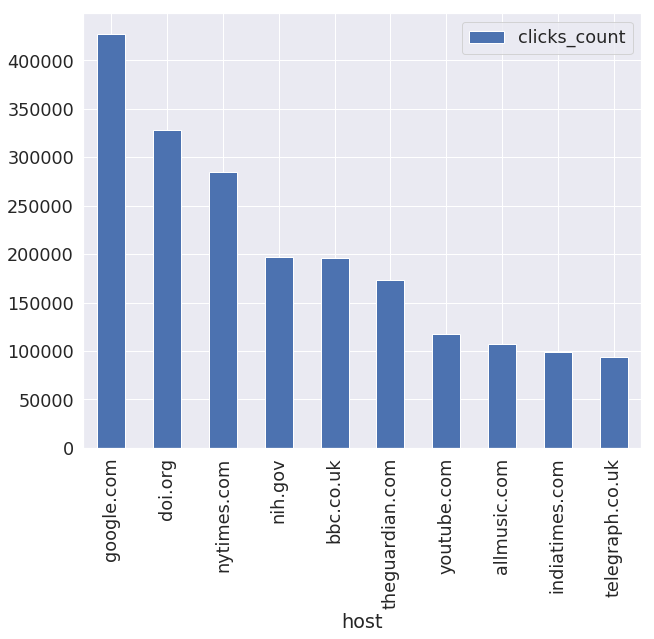

In [19]:
top_clicked_domains.head(10).plot(kind="bar", x="host", y="clicks_count")

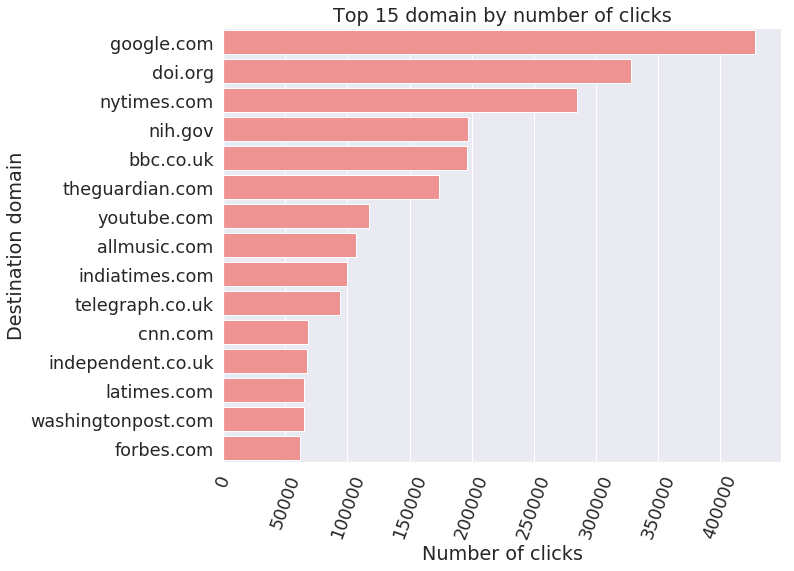

In [20]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)  # crazy big
ax=sns.barplot(y="host", x="clicks_count", data=top_clicked_domains.head(15), color=(1,0.51,0.51), orient="h")
ax.set(xlabel='Number of clicks', ylabel='Destination domain', title="Top 15 domain by number of clicks")

for item in ax.get_xticklabels():
    item.set_rotation(70)

### Where is Internet Archive?

In [21]:
references_click = anonymous_citationusage.where("action='extClick' and footnote_number is not null")

from urllib.parse import urlparse

def get_domain(row):
    try:
        parts = urlparse(row.link_url)
        url = parts.netloc
        domain_parts = tldextract.extract(url)
        return (domain_parts.domain+"."+domain_parts.suffix, 1)
    except:
        return None

spark.createDataFrame(references_click.rdd.map(get_domain).filter(lambda a: a is not None)\
        .reduceByKey(lambda a,b:a+b).map(lambda r: Row(host=r[0], clicks_count=r[1])))\
        .sort(col("clicks_count").desc()).show()

+------------+------------------+
|clicks_count|              host|
+------------+------------------+
|      881874|       archive.org|
|      424832|        google.com|
|      328452|           doi.org|
|      281599|       nytimes.com|
|      195267|           nih.gov|
|      193306|         bbc.co.uk|
|      172447|   theguardian.com|
|      116664|       youtube.com|
|      106656|      allmusic.com|
|       98105|    indiatimes.com|
|       92779|   telegraph.co.uk|
|       65433| independent.co.uk|
|       64234|       latimes.com|
|       64066|washingtonpost.com|
|       63851|           cnn.com|
|       61126|        forbes.com|
|       59148|          imdb.com|
|       52774|       twitter.com|
|       50238|        people.com|
|       46072|   dailymail.co.uk|
+------------+------------------+
only showing top 20 rows



## Page-level CTR - DESKTOP

In [22]:
pageloads_desktop = pageloads.where("mode='desktop'")
citationusage_desktop = citationusage.where("mode='desktop'")

In [23]:
loads_with_clicks = citationusage_desktop\
                .where("action='extClick' and footnote_number is not null")\
                .select("page_id", "session_token").distinct()
loads_with_clicks

DataFrame[page_id: bigint, session_token: string]

In [24]:
loads_with_clicks_counts = loads_with_clicks.groupBy("page_id").agg(count("*").alias("loads_with_clicks"))
loads_with_clicks_counts

DataFrame[page_id: bigint, loads_with_clicks: bigint]

In [25]:
pageloads_counts = pageloads_desktop.groupBy("page_id").agg(countDistinct("session_token").alias("pageloads_count"))
pageloads_counts

DataFrame[page_id: bigint, pageloads_count: bigint]

In [26]:
pageloads_counts.registerTempTable("pageloads_counts")
loads_with_clicks_counts.registerTempTable("loads_with_clicks_counts")
articles_with_references.registerTempTable("articles_with_references")


query = """
SELECT plc.page_id, plc.pageloads_count, 
        case when lwc.page_id is null then 0 else lwc.loads_with_clicks end as loads_with_clicks
FROM pageloads_counts plc
JOIN articles_with_references awr
ON plc.page_id=awr.page_id
LEFT JOIN loads_with_clicks_counts lwc
ON plc.page_id = lwc.page_id
"""

pagelevel_ct_rate = spark.sql(query).selectExpr("*", "loads_with_clicks/pageloads_count as page_ct")
pagelevel_ct_rate.cache()

DataFrame[page_id: bigint, pageloads_count: bigint, loads_with_clicks: bigint, page_ct: double]

In [27]:
pagelevel_ct_rate.count()

4012459

In [28]:
pages100loads = pagelevel_ct_rate.where("pageloads_count>=100")
pages100loads

DataFrame[page_id: bigint, pageloads_count: bigint, loads_with_clicks: bigint, page_ct: double]

### POPULARITY

In [29]:
pages_ctr = pages100loads.where("loads_with_clicks>0").select("pageloads_count", "page_ct").toPandas()
pages_ctr.head()

,pageloads_count,page_ct
0,2680,0.000373
1,2540,0.004331
2,21745,0.002115
3,2302,0.010860
4,262,0.026718


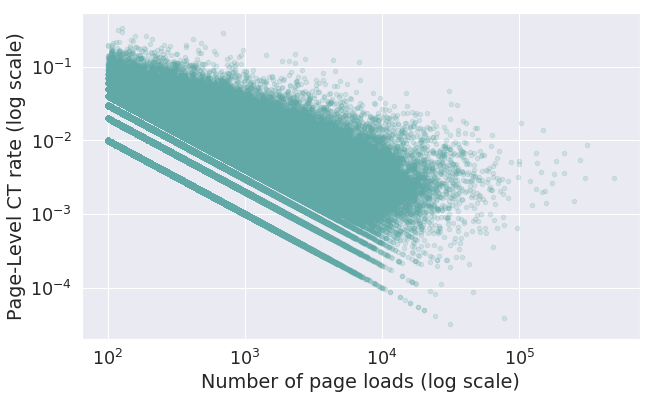

In [30]:
p = pages_ctr.plot(kind="scatter", 
               x="pageloads_count", 
               y="page_ct", alpha=0.2, 
               figsize=(10,6),
               logx=True, logy=True,
                color=(0.376, 0.663, 0.651)
              )
p.set_ylabel("Page-Level CT rate (log scale)")
p.set_xlabel("Number of page loads (log scale)")

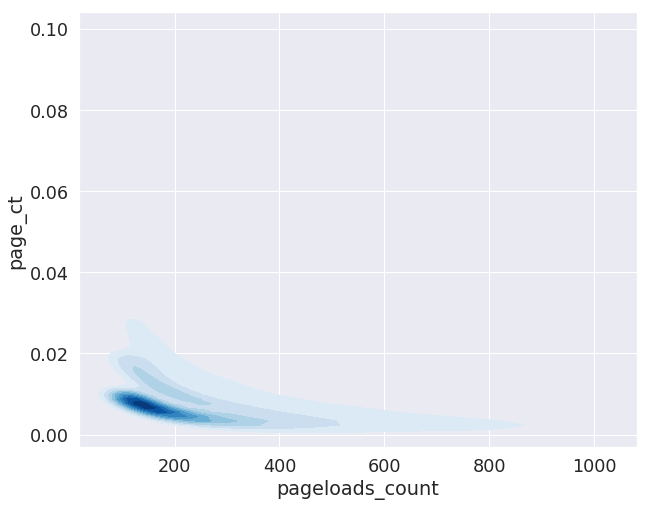

In [31]:
sample = pages_ctr[(pages_ctr.pageloads_count<1000) & (pages_ctr.page_ct<0.1)]
# sns.jointplot(sample.pageloads_count, sample.page_ct, kind="hex", color="#4CB391")
sns.kdeplot(sample.pageloads_count, sample.page_ct,
                 cmap="Blues", shade=True, shade_lowest=False)

### LENGTH

In [32]:
wikipedia_text = spark.read.parquet("april2019_wikipedia_text.parquet")
wikipedia_text

DataFrame[page_id: string, revision_id: string, text: string]

In [33]:
revision_len = wikipedia_text.selectExpr("page_id", "LENGTH(text) as text_len")
text_len = revision_len.groupBy("page_id").agg(avg("text_len").alias("text_len"))
text_len

DataFrame[page_id: string, text_len: double]

In [34]:
ct_by_len = pages100loads.join(text_len, pages100loads.page_id==text_len.page_id)\
        .where("loads_with_clicks>0").select("page_ct", "text_len").toPandas()
ct_by_len.head()

,page_ct,text_len
0,0.000373,22280.500000
1,0.004331,13759.000000
2,0.002115,56909.461538
3,0.010860,118295.600000
4,0.026718,14787.000000


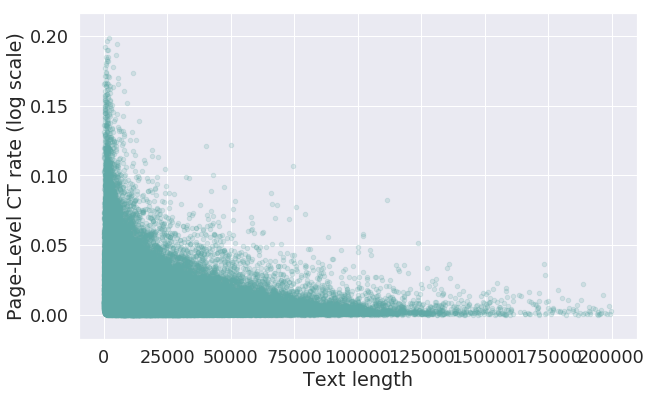

In [35]:
sample = ct_by_len[(ct_by_len.text_len<200000)&(ct_by_len.page_ct<0.2)]


p = sample.plot(kind="scatter", 
               x="text_len", 
               y="page_ct", alpha=0.2, 
               figsize=(10,6),
               #logx=True, logy=True,
                color=(0.376, 0.663, 0.651)
              )
p.set_ylabel("Page-Level CT rate (log scale)")
p.set_xlabel("Text length")

### Topics

In [36]:
article_topics_raw = sc.textFile("all_quality_and_topics.json")

In [37]:
from collections import Counter

def get_topics(line):
    try:
        row = json.loads(line)
        score = row.get("score")
        topics = score.get("drafttopic").get("score").get("probability")
        return (row.get('page_id'), [topics])
    except:
        return None
    
def average_topics(revisions):
#     print(revisions)
    topics_average = Counter()
    for r in revisions[1]:
        for t,v in r.items():
            topics_average[t] += v/len(revisions[1])
    return Row(page_id=revisions[0], topics=dict(**topics_average))

average_topics = article_topics_raw.map(get_topics).filter(lambda r: r is not None)\
        .reduceByKey(lambda a,b: a+b).map(average_topics)

In [38]:
def get_top_topic(row):
    try:
        topics_list = sorted([(t, v)for t,v in row.topics.items()], key=lambda r: -r[1])
        return Row(page_id=row.page_id, topic=topics_list[0][0])
    except:
        return None

article_topic = spark.createDataFrame(average_topics.map(get_top_topic).filter(lambda r: r is not None)).cache()
article_topic.show(5)

+--------+--------------------+
| page_id|               topic|
+--------+--------------------+
|50701200|      Culture.Sports|
|  120835| Geography.Countries|
|27119620|Culture.Language ...|
|54499335|    STEM.Meteorology|
|32014345|    Geography.Europe|
+--------+--------------------+
only showing top 5 rows



In [39]:
ct_by_topic = pages100loads.alias("pl")\
        .join(article_topic, pages100loads.page_id==article_topic.page_id)\
        .select("page_ct", "topic").toPandas()
len(ct_by_topic)

534515

In [40]:
ct_by_topic[ct_by_topic.page_ct==0].count()

page_ct    195680
topic      195680
dtype: int64

In [41]:
ct_summary = ct_by_topic.groupby("topic").agg(["mean", "count", "std"])
ct_summary.columns = ct_summary.columns.droplevel()
ct_summary.head()


,mean,count,std
topic,,,
Assistance.Article improvement and grading,0.006888,46,0.011278
Assistance.Contents systems,0.004057,231,0.008005
Assistance.Files,0.009367,52,0.012496
Assistance.Maintenance,0.007615,272,0.010968
Culture.Arts,0.007408,513,0.009620


In [42]:
df = ct_summary[ct_summary['count']>=100].sort_values("mean", ascending=False).reset_index()
df.head()

,topic,mean,count,std
0,History_And_Society.Business and economics,0.013158,19262,0.014142
1,Culture.Internet culture,0.012592,4156,0.014669
2,STEM.Technology,0.011658,17166,0.014934
3,STEM.Information science,0.011073,326,0.012909
4,STEM.Chemistry,0.010672,8074,0.012477


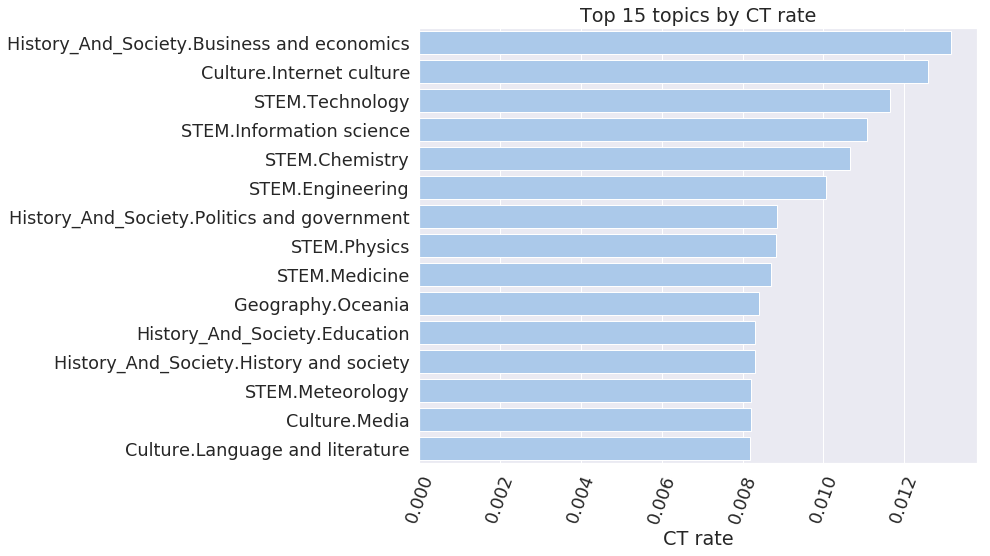

In [43]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)  # crazy big
sns.set_color_codes("pastel")
ax=sns.barplot(y="topic", x="mean", data=df.head(15), color="b", orient="h", ci=95, n_boot=100)
ax.set(xlabel='CT rate', ylabel='', title="Top 15 topics by CT rate")

for item in ax.get_xticklabels():
    item.set_rotation(70)

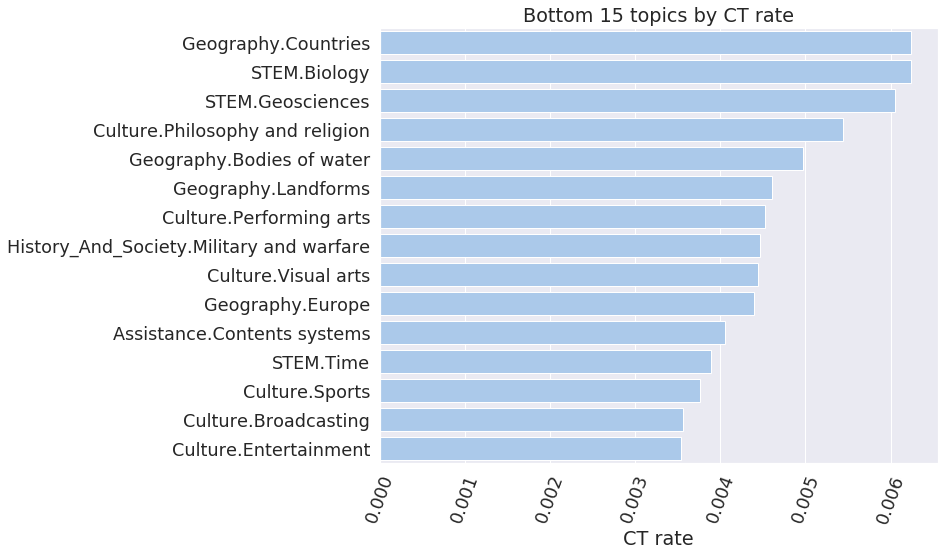

In [44]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)  # crazy big
sns.set_color_codes("pastel")
ax=sns.barplot(y="topic", x="mean", data=df.tail(15), color="b", orient="h")
ax.set(xlabel='CT rate', ylabel='', title="Bottom 15 topics by CT rate")

for item in ax.get_xticklabels():
    item.set_rotation(70)

In [45]:
for idx, row in df[['topic', 'mean']].head(100).iterrows():
    print(row['topic']+"\t"+str(row['mean']))

History_And_Society.Business and economics	0.013158414457830269
Culture.Internet culture	0.012592217238303836
STEM.Technology	0.011658386780415697
STEM.Information science	0.011072823256417494
STEM.Chemistry	0.010671908374340096
STEM.Engineering	0.010054932950631234
History_And_Society.Politics and government	0.00885484860085016
STEM.Physics	0.008825305591449548
STEM.Medicine	0.008710032842969631
Geography.Oceania	0.008411890995949627
History_And_Society.Education	0.008320571135817807
History_And_Society.History and society	0.008314440838208636
STEM.Meteorology	0.008218094301839342
Culture.Media	0.008206357950912433
Culture.Language and literature	0.008173767439420342
STEM.Space	0.00785120433955988
Assistance.Maintenance	0.007614856948533048
Culture.Food and drink	0.007518078754580135
Geography.Maps	0.007418118941454048
Culture.Arts	0.00740770336306787
Culture.Crafts and hobbies	0.007307431432022537
STEM.Mathematics	0.006874389511735343
Culture.Plastic arts	0.006768492904349376
History

In [46]:
ct_by_topic.head()

,page_ct,topic
0,0.000373,Geography.Europe
1,0.004331,STEM.Biology
2,0.002115,Culture.Language and literature
3,0.010860,History_And_Society.Politics and government
4,0.026718,STEM.Biology


In [ ]:
# ct_by_topic.to_pickle("ct_by_topic.pkl")

In [ ]:
topics_list = ct_by_topic.topic.unique()#[:2]

averages = {}
for t in topics_list:
    pages = ct_by_topic[ct_by_topic.topic==t]
    samples = []
    for i in range(0, 100):
        samples.append(float(pages.sample(len(pages), replace=True).mean()))
    averages[t] = samples

In [ ]:
import builtins
import math

averages_by_topic = []
for t,v in averages.items():
    values = sorted(v)
    ct_mean = float(builtins.sum(values)/len(values))
    low_index = 5*len(values)//100
    right_index = builtins.max(math.ceil(95*len(values)//100), len(values)-1)
    averages_by_topic.append({"topic": t,
                              "ct_mean": ct_mean, 
                              "low_index": float(values[low_index]), 
                              "right_index": float(values[low_index])})

topics_pct = pd.DataFrame(averages_by_topic).sort_values("ct_mean", ascending=False)
topics_pct.head(5)

In [ ]:
df = topics_pct.head(15)

sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)  # crazy big
sns.set_color_codes("pastel")
ax=sns.barplot(y="topic", x="ct_mean", data=df.tail(15), color="b", orient="h")
ax.set(xlabel='CT rate', ylabel='', title="Bottom 15 topics by CT rate")

for item in ax.get_xticklabels():
    item.set_rotation(70)
    
# # Find the x,y coordinates for each point
# x_coords = []
# y_coords = []
# for point_pair in ax.collections:
#     for x, y in point_pair.get_offsets():
#         x_coords.append(x)
#         y_coords.append(y)
        
# errors = [float(e) for e in df.low_index]

# ax.errorbar(x_coords, y_coords, yerr=[1,2])

In [60]:
pageloads

DataFrame[event_time: timestamp, ip_hash: string, action: string, dom_interactive_time: bigint, event_offset_time: bigint, mode: string, namespace_id: bigint, page_id: bigint, page_title: string, page_token: string, referrer: string, revision_id: bigint, session_token: string, skin: string, useragent: struct<browser_family:string,browser_major:string,browser_minor:string,device_family:string,is_bot:boolean,is_mediawiki:boolean,os_family:string,os_major:string,os_minor:string,wmf_app_version:string>, uuid: string, topic: string, seqid: bigint, recvfrom: string, wiki: string, revision: bigint, webhost: string, schema: string, year: bigint, month: bigint, day: bigint, hour: bigint, coutry: string, country_code: string, subdivision: string, continent: string]

In [73]:
pageloads_info = pageloads.selectExpr("page_id", "session_token", 
                 "country_code", "string(date(event_time)) as day", "hour")

pageloads_info.show()

+--------+--------------------+------------+----------+----+
| page_id|       session_token|country_code|       day|hour|
+--------+--------------------+------------+----------+----+
|30379834|3b339d603d8a845f2e7c|          CA|2019-03-28|  18|
|    9121|e2893c69622912ffa60b|          IN|2019-03-28|  18|
|  341023|270e2167b499bdeb35f8|          US|2019-03-28|  18|
| 2952688|463a167845e0acdefd97|          US|2019-03-28|  18|
|44843494|1a9c09f4fb80f691faaa|          PL|2019-03-28|  18|
|  283993|0086eb2753696d5e80e8|          US|2019-03-28|  18|
|  295701|7439b77376373e5358c6|          GB|2019-03-28|  18|
| 1273643|98944ce6d9a65d5fff61|          US|2019-03-28|  18|
|24920681|4c257dc827859ca5487a|          GB|2019-03-28|  18|
|  457426|9d66251684955f53b8f2|          LR|2019-03-28|  18|
|38348303|523a1abca19d9c348a89|          US|2019-03-28|  18|
|57208239|f106f03b0508ad2766ca|          US|2019-03-28|  18|
|  191987|b22081d802f5336d4754|          SE|2019-03-28|  18|
| 2554109|21c9cdc21bd3c9

In [74]:
pageviews_by_time = pageloads_info.groupBy("day", "hour").agg(count("*").alias("pageviews"))

In [75]:
pageviews_by_time_df = pageviews_by_time.toPandas().sort_values(["day", "hour"]).reset_index(drop=True)

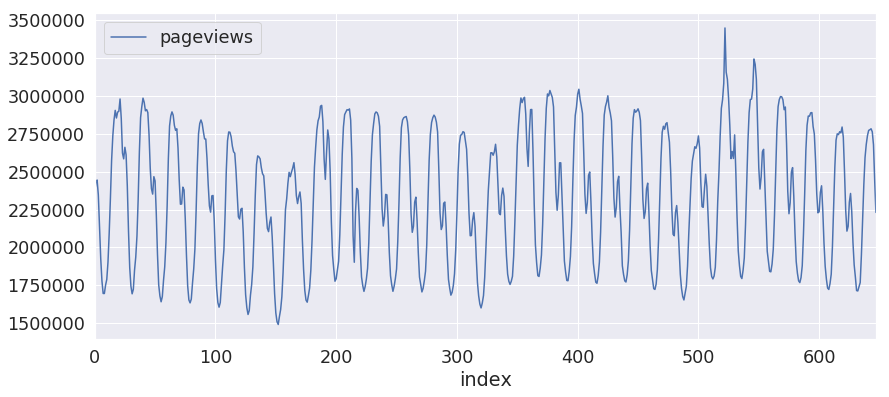

In [88]:
pageviews_by_time_df.reset_index().plot(x="index", y="pageviews", figsize=(14, 6))

In [92]:
pageloads_info_USA = pageloads.where("country_code='US'").selectExpr("page_id", "session_token", 
                 "country_code", "string(date(event_time)) as day", "hour")
pageviews_by_time_USA = pageloads_info_USA.groupBy("day", "hour").agg(count("*").alias("pageviews"))
pageviews_by_time_USA_df = pageviews_by_time_USA.toPandas().sort_values(["day", "hour"]).reset_index(drop=True)

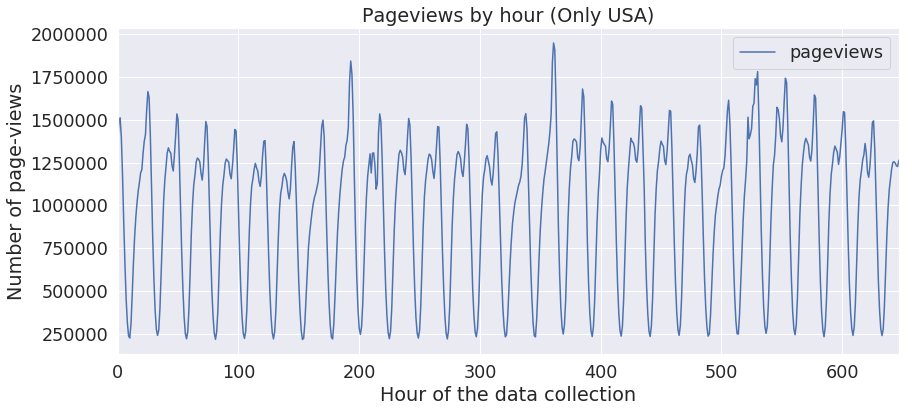

In [94]:
p = pageviews_by_time_USA_df.reset_index().plot(x="index", y="pageviews", figsize=(14, 6))
p.set_xlabel("Hour of the data collection")
p.set_ylabel("Number of page-views")
p.set_title("Pageviews by hour (Only USA)")

--------

# CT RATE BY TIME

In [103]:
loads_with_clicks_by_time = citationusage_desktop\
                .where("action='extClick' and footnote_number is not null and country_code='US'")\
                .selectExpr("page_id", "session_token", "string(date(event_time)) as day", "hour").distinct()\
                .groupBy("day", "hour").agg(count("*").alias("loads_with_clicks"))

loads_with_clicks_by_time

DataFrame[day: string, hour: bigint, loads_with_clicks: bigint]

In [104]:
pageloads_USA_by_time = pageloads_desktop.where("country_code='US'")\
                .selectExpr("page_id", "session_token", "string(date(event_time)) as day", "hour").distinct()\
                .groupBy("day", "hour").agg(count("*").alias("pageviews"))
pageloads_USA_by_time

DataFrame[day: string, hour: bigint, pageviews: bigint]

In [111]:
ct_rate_by_time = pageloads_USA_by_time.alias("pl").join(loads_with_clicks_by_time, 
                           (pageloads_USA_by_time.day==loads_with_clicks_by_time.day) &
                           (pageloads_USA_by_time.hour==loads_with_clicks_by_time.hour)
                          ).selectExpr("pl.*", "loads_with_clicks", "loads_with_clicks/pageviews as ct_rate")\
                        .toPandas().sort_values(["day", "hour"]).reset_index(drop=True)

ct_rate_by_time.head()

,day,hour,pageviews,loads_with_clicks,ct_rate
0,2019-03-24,0,287555,1421,0.004942
1,2019-03-24,1,308092,1490,0.004836
2,2019-03-24,2,308846,1552,0.005025
3,2019-03-24,3,290228,1462,0.005037
4,2019-03-24,4,248594,1210,0.004867


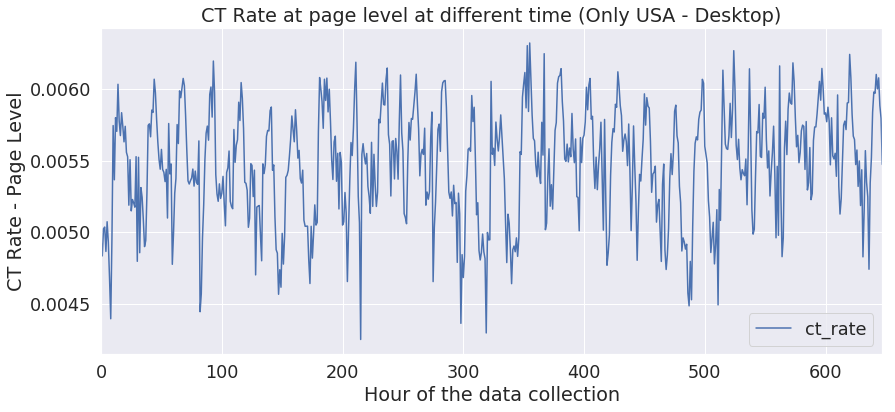

In [119]:
p = ct_rate_by_time.reset_index().plot(x="index", y="ct_rate", figsize=(14, 6))
p.set_xlabel("Hour of the data collection")
p.set_ylabel("CT Rate - Page Level")
p.set_title("CT Rate at page level at different time (Only USA - Desktop)")

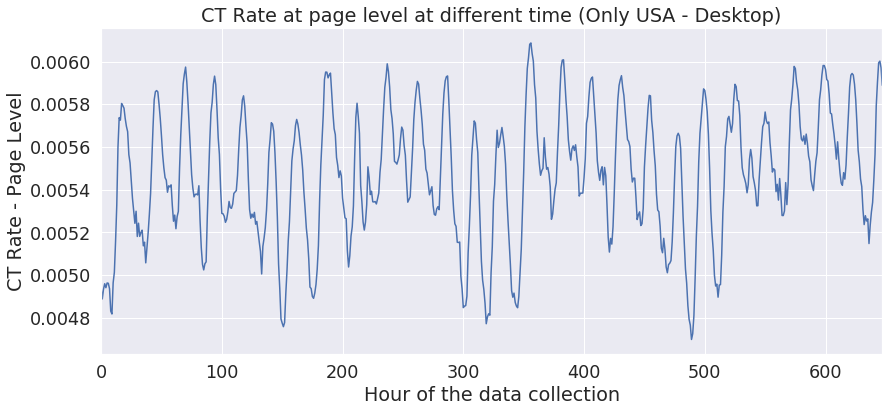

In [127]:
p=ct_rate_by_time.reset_index().ct_rate.rolling(6, min_periods=1).mean().plot(x="index", y="ct_rate", figsize=(14, 6))
p.set_xlabel("Hour of the data collection")
p.set_ylabel("CT Rate - Page Level")
p.set_title("CT Rate at page level at different time (Only USA - Desktop)")